In [10]:
#Setting up prerequisites
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
from sklearn.metrics import mean_squared_error

from numpy import matrix

print("Setup Complete\n")

Setup Complete



In [11]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations,R_base):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.R_base=R_base

    def train(self):
        # Create and initialize P and Q matrices with random values
        
        self.P = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K))
        
        
        """
        np.random.normal return the array of specified size by allocating random values according to the Gaussian (Normal) 
        distribution with (mean = loc , SD = scale). By default mean=0.
        
        Helpful link : https://www.geeksforgeeks.org/rand-vs-normal-numpy-random-python/
        
        """
        
        #(np.where(self.R != 0)) -> returns two lists M,N where Mi,Ni are row and coulmn of non-zero elements.

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R_base[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        mse=0.0
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            x=self.sgd()
            mse1=mse
            mse = self.mse()
            if i!=0 and mse > mse1+3:
                print("optimality reached at Iteration : %d" % (i))
                break
            training_process.append((i, mse))
            print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R_base.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        e=0.0
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e1=e
            e = (r - prediction)

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (2* e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (2 * e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.P.dot(self.Q.T)

In [12]:
class MF1():

    def __init__(self, R, K, alpha, beta, iterations,R_base):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.R_base=R_base

    def train(self):
        # Create and initialize P and Q matrices with random values
        
        self.P = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K))
        
        
        """
        np.random.normal return the array of specified size by allocating random values according to the Gaussian (Normal) 
        distribution with (mean = loc , SD = scale). By default mean=0.
        
        Helpful link : https://www.geeksforgeeks.org/rand-vs-normal-numpy-random-python/
        
        """

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        #(np.where(self.R != 0)) -> returns two lists M,N where Mi,Ni are row and coulmn of non-zero elements.

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R_base[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        mse=0.0
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            x=self.sgd()
            mse1=mse
            mse = self.mse()
            if i!=0 and mse > mse1+3:
                print("optimality reached at Iteration : %d" % (i))
                break
            training_process.append((i, mse))
            print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R_base.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        e=0.0
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e1=e
            e = (r - prediction)
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (2* e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (2 * e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        #prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
        #return self.P.dot(self.Q.T)

In [13]:
class Stack:
     def __init__(self,items):
         self.items = items

     def isEmpty(self):
         return self.items == []

     def push(self, item):
         self.items.append(item)

     def pop(self):
         return self.items.pop()

     def peek(self):
         return self.items[len(self.items)-1]

     def size(self):
         return len(self.items)

In [14]:
### Using Movielens 100K dataset for the training and testing ##

dataFile=r"D:\Academics\7th sem\Data sciences\Project\ml-100k\u.data"
colNames=['UserID','MovieID','Rating','TimeStamp']
data=pd.read_csv(dataFile,sep="\t",names=colNames,header=None)
data.head()
#data.shape[0]

,UserID,MovieID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [15]:
###  Dropping timestamp as its unnecessary in this context  ###
data = data.drop(data.columns[[3]], axis=1)
data.head()

,UserID,MovieID,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [16]:
"""
Converting the ratings to matrix form such that
R[User_ID][Movie_ID] = <rating given>

"""
mat=data.pivot(*data.columns)
R=np.asarray(mat)
print(R[:10,:10]) 

[[ 5.  3.  4.  3.  3.  5.  4.  1.  5.  3.]
 [ 4. nan nan nan nan nan nan nan nan  2.]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [ 4.  3. nan nan nan nan nan nan nan nan]
 [ 4. nan nan nan nan nan  2.  4.  4. nan]
 [nan nan nan  5. nan nan  5.  5.  5.  4.]
 [nan nan nan nan nan nan  3. nan nan nan]
 [nan nan nan nan nan  5.  4. nan nan nan]
 [ 4. nan nan  4. nan nan  4. nan  4. nan]]


In [17]:
"""
Since some of the users may not rate some movies, we have nan values after converting to matrix form
We convert all those nan values to 0

"""

R=np.nan_to_num(R)
#[:200,:200]
R=np.float64(R) #for calculation purpose
R1=R
R[:10,:10]

array([[5., 3., 4., 3., 3., 5., 4., 1., 5., 3.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 2., 4., 4., 0.],
       [0., 0., 0., 5., 0., 0., 5., 5., 5., 4.],
       [0., 0., 0., 0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 4., 0., 0., 0.],
       [4., 0., 0., 4., 0., 0., 4., 0., 4., 0.]])

In [20]:
MAE_normalMF=[]
MAE_biasMF=[]


for observations in range(10):
    print("##############   Iteration %d ##################"%(observations+1))
    stackFactors1=Stack([10])
    stackIterations1=Stack([50])
    stackLearnRate1=Stack([0.01])
    stackRegularions1=Stack([0.01])
    """
    We try to analyze the efficiency(based on MAE) of base Matrix Factorization and Deep Matrix Factorization 
    with the same training and testing sets. For that we try to divide the dataset into 70:30
    ratios for training and testing respectively.We divide randomly and then make those values 0's and then try
    to find these values based on training dataset.

    """
    prop_i = int(min(R.shape[0],R.shape[1])*0.3)
    prop_j = int(R.shape[1] * 0.2)
    #print(R.size)
    
    print("####################        Without bias #################")
    R1=R
    R1=np.rint(R1)

    #Randomly choose indices of the numpy array:
    i = [np.random.choice(range(R.shape[0])) for _ in range(prop_i)]
    j = [np.random.choice(range(R.shape[1])) for _ in range(prop_i)]

    R1[i,j]=0

    #print(len(i))
    #print(len(j))
    print("Original:\n",R)
    print("Test Set:\n",R1)
    R=np.rint(R)
    u,v=R.shape
    Res=np.zeros([u,v])
    xs, ys = R.nonzero()


    k=stackFactors1.pop()
    t=stackIterations1.pop()
    alppa=stackLearnRate1.pop()
    betta=stackRegularions1.pop()

    mf = MF(R1, K=k, alpha=alppa, beta=betta, iterations=t,R_base=R1)

    training_process = mf.train()

    print()
    print("P x Q:")
    print(mf.full_matrix())


    predicted = mf.full_matrix()
    for x, y in zip(xs, ys):
        R1[x,y]= mf.R[x, y] - predicted[x, y]
    for t in range(len(Res)):  
        for p in range(len(Res[0])):
            Res[t][p] = Res[t][p] + predicted[t,p]
    print()
    print()

    print()
    print()
    print("Final result is :")
    Res=np.rint(Res)
    for t in range(Res.shape[0]):
        for p in range(Res.shape[1]):
            if Res[t,p]>5:
                Res[t,p]=5
            if Res[t,p]<1:
                Res[t,p]=1
    print(Res)
    msef=0.0
    c=int(0)
    for i1 in range(len(i)):
        for i2 in range(len(j)):
            if R.item(i[i1],j[i2])!=0:
                #print(i1,i2)
                msef = msef + abs(R.item((i[i1],j[i2]))-(Res).item((i[i1],j[i2])))
                c=c+1
    msef = (msef/c)
    print()
    print("MAE = ",msef)
    print()
    print()
    MAE_normalMF.append(msef)
    
    print("################# With Bias ######################")    
    stackFactors1=Stack([10])
    stackIterations1=Stack([50])
    stackLearnRate1=Stack([0.01])
    stackRegularions1=Stack([0.01])
    R1=R
    R1=np.rint(R1)
    R1[i,j]=0
    
    R=np.rint(R)
    u,v=R.shape
    Res=np.zeros([u,v])
    xs, ys = R.nonzero()


    k=stackFactors1.pop()
    t=stackIterations1.pop()
    alppa=stackLearnRate1.pop()
    betta=stackRegularions1.pop()

    mf = MF1(R1, K=k, alpha=alppa, beta=betta, iterations=t,R_base=R1)

    training_process = mf.train()

    print()
    print("P x Q:")
    print(mf.full_matrix())


    predicted = mf.full_matrix()
    for x, y in zip(xs, ys):
        R1[x,y]= mf.R[x, y] - predicted[x, y]
    for t in range(len(Res)):  
        for p in range(len(Res[0])):
            Res[t][p] = Res[t][p] + predicted[t,p]
    print()
    print()

    print()
    print()
    print("Final result is :")
    Res=np.rint(Res)
    for t in range(Res.shape[0]):
        for p in range(Res.shape[1]):
            if Res[t,p]>5:
                Res[t,p]=5
            if Res[t,p]<1:
                Res[t,p]=1
    print(Res)
    msef=0.0
    c=int(0)
    for i1 in range(len(i)):
        for i2 in range(len(j)):
            if R.item(i[i1],j[i2])!=0:
                #print(i1,i2)
                msef = msef + abs(R.item((i[i1],j[i2]))-(Res).item((i[i1],j[i2])))
                c=c+1
    msef = (msef/c)
    print()
    print("MAE = ",msef)
    print()
    print()
    MAE_biasMF.append(msef)


##############   Iteration 1 ##################
####################        Without bias #################
Original:
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Test Set:
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Iteration: 1 ; error = 353.5776
Iteration: 2 ; error = 305.4710
Iteration: 3 ; error = 292.1280
Iteration: 4 ; error = 280.9186
Iteration: 5 ; error = 272.4684
Iteration: 6 ; error = 265.9152
Iteration: 7 ; error = 260.9784
Iteration: 8 ; error = 257.5752
Iteration: 9 ; error = 253.2533
Iteration: 10 ; error = 250.3072
Iteration: 11 ; error = 248.7206
Iteration: 12 ; error = 246.5055
Iteration: 13 ; error = 244.8480
Iteration: 14 ; error = 244.1334
Iteration: 15 ; error = 243.5182
Iteration: 16 ; error = 241.6402
Iteration: 17 ; error = 240.3303
Iterati

Iteration: 10 ; error = 241.2456
Iteration: 11 ; error = 238.4600
Iteration: 12 ; error = 236.0892
Iteration: 13 ; error = 234.0935
Iteration: 14 ; error = 232.3599
Iteration: 15 ; error = 230.8770
Iteration: 16 ; error = 229.5544
Iteration: 17 ; error = 228.4516
Iteration: 18 ; error = 227.5366
Iteration: 19 ; error = 226.6621
Iteration: 20 ; error = 225.8865
Iteration: 21 ; error = 225.1575
Iteration: 22 ; error = 224.5484
Iteration: 23 ; error = 223.9033
Iteration: 24 ; error = 223.4540
Iteration: 25 ; error = 222.9725
Iteration: 26 ; error = 222.5595
Iteration: 27 ; error = 222.2666
Iteration: 28 ; error = 221.8473
Iteration: 29 ; error = 221.4563
Iteration: 30 ; error = 221.1673
Iteration: 31 ; error = 220.7836
Iteration: 32 ; error = 220.5249
Iteration: 33 ; error = 220.3068
Iteration: 34 ; error = 220.1585
Iteration: 35 ; error = 219.8323
Iteration: 36 ; error = 219.7173
Iteration: 37 ; error = 219.4386
Iteration: 38 ; error = 219.2508
Iteration: 39 ; error = 219.0566
Iteration:

Iteration: 21 ; error = 238.3558
Iteration: 22 ; error = 237.1030
Iteration: 23 ; error = 236.0002
Iteration: 24 ; error = 236.9889
Iteration: 25 ; error = 235.3705
Iteration: 26 ; error = 236.2812
Iteration: 27 ; error = 235.8783
Iteration: 28 ; error = 235.6189
Iteration: 29 ; error = 234.3181
Iteration: 30 ; error = 235.2974
Iteration: 31 ; error = 234.9597
Iteration: 32 ; error = 234.2923
Iteration: 33 ; error = 234.8860
Iteration: 34 ; error = 235.0121
Iteration: 35 ; error = 234.5751
Iteration: 36 ; error = 233.8704
Iteration: 37 ; error = 234.2492
Iteration: 38 ; error = 234.7377
Iteration: 39 ; error = 233.5024
Iteration: 40 ; error = 233.3448
Iteration: 41 ; error = 233.4561
Iteration: 42 ; error = 233.5161
Iteration: 43 ; error = 233.4205
Iteration: 44 ; error = 233.6628
Iteration: 45 ; error = 233.4394
Iteration: 46 ; error = 233.4999
Iteration: 47 ; error = 234.3846
Iteration: 48 ; error = 234.0223
Iteration: 49 ; error = 233.7275
Iteration: 50 ; error = 233.7900

P x Q:
[[

Iteration: 44 ; error = 219.1595
Iteration: 45 ; error = 219.0211
Iteration: 46 ; error = 219.0034
Iteration: 47 ; error = 218.8181
Iteration: 48 ; error = 218.6190
Iteration: 49 ; error = 218.5629
Iteration: 50 ; error = 218.5348

P x Q:
[[4.10567052 3.35886337 2.79496245 ... 3.33827225 3.50910728 3.29334524]
 [4.04886674 3.72827499 1.27321381 ... 3.76632781 3.75436129 3.44044762]
 [2.92731538 1.98600007 5.99547029 ... 2.13709855 2.98191784 2.88238065]
 ...
 [4.46245459 3.27266916 3.61116371 ... 3.29088537 3.65661836 3.55688467]
 [4.10753733 4.08625808 2.1250296  ... 4.03904661 4.21376181 3.88283397]
 [3.50226219 3.51715177 1.67004139 ... 2.68295259 3.0725624  3.21932954]]




Final result is :
[[4. 3. 3. ... 3. 4. 3.]
 [4. 4. 1. ... 4. 4. 3.]
 [3. 2. 5. ... 2. 3. 3.]
 ...
 [4. 3. 4. ... 3. 4. 4.]
 [4. 4. 2. ... 4. 4. 4.]
 [4. 4. 2. ... 3. 3. 3.]]
MAE =  0.4703379815646419


##############   Iteration 6 ##################
####################        Without bias #################
Orig





Final result is :
[[4. 4. 2. ... 1. 2. 3.]
 [4. 4. 3. ... 1. 3. 3.]
 [2. 3. 4. ... 1. 2. 1.]
 ...
 [4. 4. 2. ... 1. 2. 2.]
 [4. 4. 3. ... 1. 2. 2.]
 [4. 3. 3. ... 1. 2. 2.]]
MAE =  0.5260554672319379


################# With Bias ######################
Iteration: 1 ; error = 302.2768
Iteration: 2 ; error = 294.2277
Iteration: 3 ; error = 288.4588
Iteration: 4 ; error = 281.1947
Iteration: 5 ; error = 271.9329
Iteration: 6 ; error = 262.9436
Iteration: 7 ; error = 255.4908
Iteration: 8 ; error = 249.6485
Iteration: 9 ; error = 245.1453
Iteration: 10 ; error = 241.5252
Iteration: 11 ; error = 238.6170
Iteration: 12 ; error = 236.2154
Iteration: 13 ; error = 234.1928
Iteration: 14 ; error = 232.5066
Iteration: 15 ; error = 231.0545
Iteration: 16 ; error = 229.7578
Iteration: 17 ; error = 228.6788
Iteration: 18 ; error = 227.7849
Iteration: 19 ; error = 226.8436
Iteration: 20 ; error = 226.1013
Iteration: 21 ; error = 225.4758
Iteration: 22 ; error = 224.7804
Iteration: 23 ; error = 22

Iteration: 5 ; error = 269.7552
Iteration: 6 ; error = 263.3537
Iteration: 7 ; error = 258.9698
Iteration: 8 ; error = 255.1901
Iteration: 9 ; error = 252.5015
Iteration: 10 ; error = 248.6798
Iteration: 11 ; error = 247.3262
Iteration: 12 ; error = 244.9114
Iteration: 13 ; error = 243.4292
Iteration: 14 ; error = 242.0188
Iteration: 15 ; error = 240.9452
Iteration: 16 ; error = 239.5353
Iteration: 17 ; error = 239.7388
Iteration: 18 ; error = 238.1551
Iteration: 19 ; error = 238.2628
Iteration: 20 ; error = 237.3997
Iteration: 21 ; error = 237.0618
Iteration: 22 ; error = 236.1323
Iteration: 23 ; error = 235.8606
Iteration: 24 ; error = 235.9985
Iteration: 25 ; error = 235.2554
Iteration: 26 ; error = 235.8650
Iteration: 27 ; error = 233.8393
Iteration: 28 ; error = 234.4081
Iteration: 29 ; error = 234.9486
Iteration: 30 ; error = 234.2427
Iteration: 31 ; error = 233.0241
Iteration: 32 ; error = 234.5954
Iteration: 33 ; error = 233.8325
Iteration: 34 ; error = 234.0112
Iteration: 35 ;

Iteration: 28 ; error = 222.0960
Iteration: 29 ; error = 221.9093
Iteration: 30 ; error = 221.4233
Iteration: 31 ; error = 221.1775
Iteration: 32 ; error = 220.8590
Iteration: 33 ; error = 220.6024
Iteration: 34 ; error = 220.3860
Iteration: 35 ; error = 220.1367
Iteration: 36 ; error = 219.9209
Iteration: 37 ; error = 219.6546
Iteration: 38 ; error = 219.5314
Iteration: 39 ; error = 219.2967
Iteration: 40 ; error = 219.2361
Iteration: 41 ; error = 218.9533
Iteration: 42 ; error = 218.7830
Iteration: 43 ; error = 218.6913
Iteration: 44 ; error = 218.5913
Iteration: 45 ; error = 218.3734
Iteration: 46 ; error = 218.3921
Iteration: 47 ; error = 218.2180
Iteration: 48 ; error = 218.0135
Iteration: 49 ; error = 217.9746
Iteration: 50 ; error = 217.9312

P x Q:
[[3.86894627 3.12014421 2.77199003 ... 3.37747829 3.46974409 3.20446281]
 [4.07851455 3.62278032 2.55157487 ... 3.7340675  3.58568897 3.44287311]
 [3.46539044 2.15780857 1.42696467 ... 2.79336538 2.6941148  2.6416327 ]
 ...
 [4.76702

In [21]:
res = "\n".join("{} \t {}".format(x, y) for x, y in zip(MAE_normalMF, MAE_biasMF))
print(res)

0.557102458124864 	 0.4892321078964542
0.48576443057722307 	 0.4494929797191888
0.5364633442370599 	 0.4854723879161054
0.5360218441503886 	 0.4803612686410418
0.49870007090522334 	 0.4703379815646419
0.5144142302187692 	 0.4610509098343897
0.5260554672319379 	 0.48277689454160044
0.5066763777615926 	 0.4688031075503763
0.5241157556270096 	 0.4684485530546624
0.5396429257055096 	 0.5093108082165483


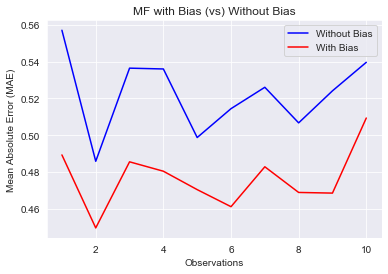

In [23]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.plot(x,MAE_normalMF,color="b",label='Without Bias')
plt.plot(x,MAE_biasMF,color="r",label='With Bias')
plt.title("MF with Bias (vs) Without Bias")
plt.xlabel("Observations")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()